# RAG Performance Analysis
## Comprehensive evaluation of RAG vs Simple model performance

In [1]:
# =============================
# 1. Imports and Setup
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams.update({
    "pdf.fonttype": 42, 
    "ps.fonttype": 42,
    "savefig.transparent": True
})

In [2]:
# =============================
# 2. Define Data Paths
# =============================
csv_paths = {
    "LLama-3B": {
        "TF": {
            "1hop": "LLama-3B/data/1hop_true_and_false.csv",
            "2hop": "LLama-3B/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "LLama-3B/data/1hop_MCQ.csv",
            "2hop": "LLama-3B/data/2hop_MCQ.csv",
        }
    },
    "SmolLM3-3B": {
        "TF": {
            "1hop": "SmolLM3-3B/data/1hop_true_and_false.csv",
            "2hop": "SmolLM3-3B/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "SmolLM3-3B/data/1hop_MCQ.csv",
            "2hop": "SmolLM3-3B/data/2hop_MCQ.csv",
        }
    },
    "Qwen3-3B": {
        "TF": {
            "1hop": "Qwen3-3B/data/1hop_true_and_false.csv",
            "2hop": "Qwen3-3B/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "Qwen3-3B/data/1hop_MCQ.csv",
            "2hop": "Qwen3-3B/data/2hop_MCQ.csv",
        }
    },
    "LLama-8B": {
        "TF": {
            "1hop": "LLama-8B/verified/data/1hop_true_and_false.csv",
            "2hop": "LLama-8B/verified/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "LLama-8B/verified/data/1hop_MCQ.csv",
            "2hop": "LLama-8B/verified/data/2hop_MCQ.csv",
        }
    },
    "Mistral-7B": {
        "TF": {
            "1hop": "Mistral-7B/verified/data/1hop_true_and_false.csv",
            "2hop": "Mistral-7B/verified/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "Mistral-7B/verified/data/1hop_MCQ.csv",
            "2hop": "Mistral-7B/verified/data/2hop_MCQ.csv",
        }
    },
    "Mistral-8x7B": {
        "TF": {
            "1hop": "Mistral-8x7B/verified/data/1hop_true_and_false.csv",
            "2hop": "Mistral-8x7B/verified/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "Mistral-8x7B/verified/data/1hop_MCQ.csv",
            "2hop": "Mistral-8x7B/verified/data/2hop_MCQ.csv",
        }
    },
    "LLama-70B": {
        "TF": {
            "1hop": "LLama-70B/verified/data/1hop_true_and_false.csv",
            "2hop": "LLama-70B/verified/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "LLama-70B/verified/data/1hop_MCQ.csv",
            "2hop": "LLama-70B/verified/data/2hop_MCQ.csv",
        }
    },
    "GPT-5-mini": {
        "TF": {
            "1hop": "GPT-5-mini/verified/data/1hop_true_and_false.csv",
            "2hop": "GPT-5-mini/verified/data/2hop_true_and_false.csv",
        },
        "MCQ": {
            "1hop": "GPT-5-mini/verified/data/1hop_MCQ.csv",
            "2hop": "GPT-5-mini/verified/data/2hop_MCQ.csv",
        }
    }
}

In [3]:
# =============================
# 3. Metric Calculation Functions
# =============================
def calculate_tf_metrics(df, model_name):
    """Calculate comprehensive metrics for True/False questions"""
    metrics = {}
    valid_mask = ~pd.isna(df['answer']) & ~pd.isna(df[model_name])
    y_true = df.loc[valid_mask, 'answer'].astype(str).str.lower()
    y_pred = df.loc[valid_mask, model_name].astype(str).str.lower()
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    
    # Macro averages for overall performance
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    metrics['precision_macro'] = p
    metrics['recall_macro'] = r
    metrics['f1_macro'] = f
    metrics['n_samples'] = len(y_true)
    
    return metrics

def calculate_mcq_metrics(df, model_name):
    """Calculate comprehensive metrics for Multiple Choice Questions"""
    metrics = {}
    valid_mask = ~pd.isna(df['standardized_answer']) & ~pd.isna(df[model_name])
    y_true = df.loc[valid_mask, 'standardized_answer'].astype(str)
    y_pred = df.loc[valid_mask, model_name].astype(str)
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    
    # Macro averages for multi-class
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    metrics['precision_macro'] = p
    metrics['recall_macro'] = r
    metrics['f1_macro'] = f
    metrics['n_samples'] = len(y_true)
    
    return metrics

In [4]:
# =============================
# 4. Collect All Metrics
# =============================
all_results = []
detailed_metrics = {}  # Store detailed metrics for deeper analysis

for model, qtypes in csv_paths.items():
    for qtype, hops in qtypes.items():
        for hop, path in hops.items():
            print(f"Processing: {model} - {qtype} - {hop}")
            
            try:
                df = pd.read_csv(path)
                
                if qtype == "TF":
                    rag_metrics = calculate_tf_metrics(df, 'with_context_parsed')
                    simple_metrics = calculate_tf_metrics(df, 'without_context_parsed')
                else:
                    rag_metrics = calculate_mcq_metrics(df, 'with_context_parsed')
                    simple_metrics = calculate_mcq_metrics(df, 'without_context_parsed')
                
                # Store detailed metrics
                key = f"{model}_{qtype}_{hop}"
                detailed_metrics[key] = {
                    'rag_metrics': rag_metrics,
                    'simple_metrics': simple_metrics
                }
                
                # Main results dataframe with all metrics
                result_row = {
                    'model': model,
                    'qtype': qtype,
                    'hop': hop,
                    # Accuracy
                    'RAG_accuracy': rag_metrics['accuracy'],
                    'Simple_accuracy': simple_metrics['accuracy'],
                    'Improvement_accuracy': rag_metrics['accuracy'] - simple_metrics['accuracy'],
                    # Precision
                    'RAG_precision': rag_metrics['precision_macro'],
                    'Simple_precision': simple_metrics['precision_macro'],
                    'Improvement_precision': rag_metrics['precision_macro'] - simple_metrics['precision_macro'],
                    # Recall
                    'RAG_recall': rag_metrics['recall_macro'],
                    'Simple_recall': simple_metrics['recall_macro'],
                    'Improvement_recall': rag_metrics['recall_macro'] - simple_metrics['recall_macro'],
                    # F1 Score
                    'RAG_f1': rag_metrics['f1_macro'],
                    'Simple_f1': simple_metrics['f1_macro'],
                    'Improvement_f1': rag_metrics['f1_macro'] - simple_metrics['f1_macro'],
                    # Sample size
                    'n_samples': rag_metrics['n_samples']
                }
                
                # For backward compatibility
                result_row['RAG'] = result_row['RAG_accuracy']
                result_row['Simple'] = result_row['Simple_accuracy']
                result_row['Improvement'] = result_row['Improvement_accuracy']
                
                all_results.append(result_row)
                
            except FileNotFoundError:
                print(f"  File not found: {path}")
            except Exception as e:
                print(f"  Error processing {path}: {str(e)}")

results_df = pd.DataFrame(all_results)
print("\n✓ Results DataFrame created successfully!")
print(f"Shape: {results_df.shape}")
print(f"Models: {results_df['model'].nunique()}")
print(f"Total experiments: {len(results_df)}")

Processing: LLama-3B - TF - 1hop
Processing: LLama-3B - TF - 2hop
Processing: LLama-3B - MCQ - 1hop
Processing: LLama-3B - MCQ - 2hop
Processing: SmolLM3-3B - TF - 1hop
Processing: SmolLM3-3B - TF - 2hop
Processing: SmolLM3-3B - MCQ - 1hop
Processing: SmolLM3-3B - MCQ - 2hop
Processing: Qwen3-3B - TF - 1hop
Processing: Qwen3-3B - TF - 2hop
Processing: Qwen3-3B - MCQ - 1hop
Processing: Qwen3-3B - MCQ - 2hop
Processing: LLama-8B - TF - 1hop
Processing: LLama-8B - TF - 2hop
Processing: LLama-8B - MCQ - 1hop
Processing: LLama-8B - MCQ - 2hop
Processing: Mistral-7B - TF - 1hop
Processing: Mistral-7B - TF - 2hop
Processing: Mistral-7B - MCQ - 1hop
Processing: Mistral-7B - MCQ - 2hop
Processing: Mistral-8x7B - TF - 1hop
Processing: Mistral-8x7B - TF - 2hop
Processing: Mistral-8x7B - MCQ - 1hop
Processing: Mistral-8x7B - MCQ - 2hop
Processing: LLama-70B - TF - 1hop
Processing: LLama-70B - TF - 2hop
Processing: LLama-70B - MCQ - 1hop
Processing: LLama-70B - MCQ - 2hop
Processing: GPT-5-mini - T

In [5]:
# =============================
# 5. Data Overview
# =============================
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print("\nFirst few rows:")
display(results_df.head())
print("\nSummary statistics:")
display(results_df[['RAG', 'Simple', 'Improvement']].describe())

DATA OVERVIEW

First few rows:


,model,qtype,hop,RAG_accuracy,Simple_accuracy,Improvement_accuracy,RAG_precision,Simple_precision,Improvement_precision,RAG_recall,Simple_recall,Improvement_recall,RAG_f1,Simple_f1,Improvement_f1,n_samples,RAG,Simple,Improvement
0,LLama-3B,TF,1hop,0.912,0.804,0.108,0.912925,0.844467,0.068459,0.915158,0.816927,0.098231,0.911931,0.801687,0.110244,500,0.912,0.804,0.108
1,LLama-3B,TF,2hop,0.858,0.816,0.042,0.871465,0.814972,0.056493,0.865221,0.815620,0.049601,0.857795,0.815243,0.042551,500,0.858,0.816,0.042
2,LLama-3B,MCQ,1hop,0.864,0.662,0.202,0.589350,0.492510,0.096840,0.714408,0.620524,0.093884,0.625133,0.458185,0.166948,500,0.864,0.662,0.202
3,LLama-3B,MCQ,2hop,0.694,0.614,0.080,0.428145,0.402196,0.025949,0.502654,0.543682,-0.041028,0.375145,0.333627,0.041517,500,0.694,0.614,0.080
4,SmolLM3-3B,TF,1hop,0.956,0.782,0.174,0.956011,0.823077,0.132934,0.955395,0.795894,0.159501,0.955687,0.779330,0.176357,500,0.956,0.782,0.174



Summary statistics:


,RAG,Simple,Improvement
count,32.000000,32.000000,32.000000
mean,0.851282,0.802082,0.049199
std,0.098650,0.129877,0.081606
min,0.628000,0.446000,-0.114000
25%,0.779000,0.758000,0.000000
50%,0.881000,0.832000,0.032000
75%,0.918500,0.869970,0.069500
max,0.978000,0.980000,0.310000


## Main Visualizations


Generating Side-by-side Heatmaps: Simple (left), RAG (middle), Δ (right)...


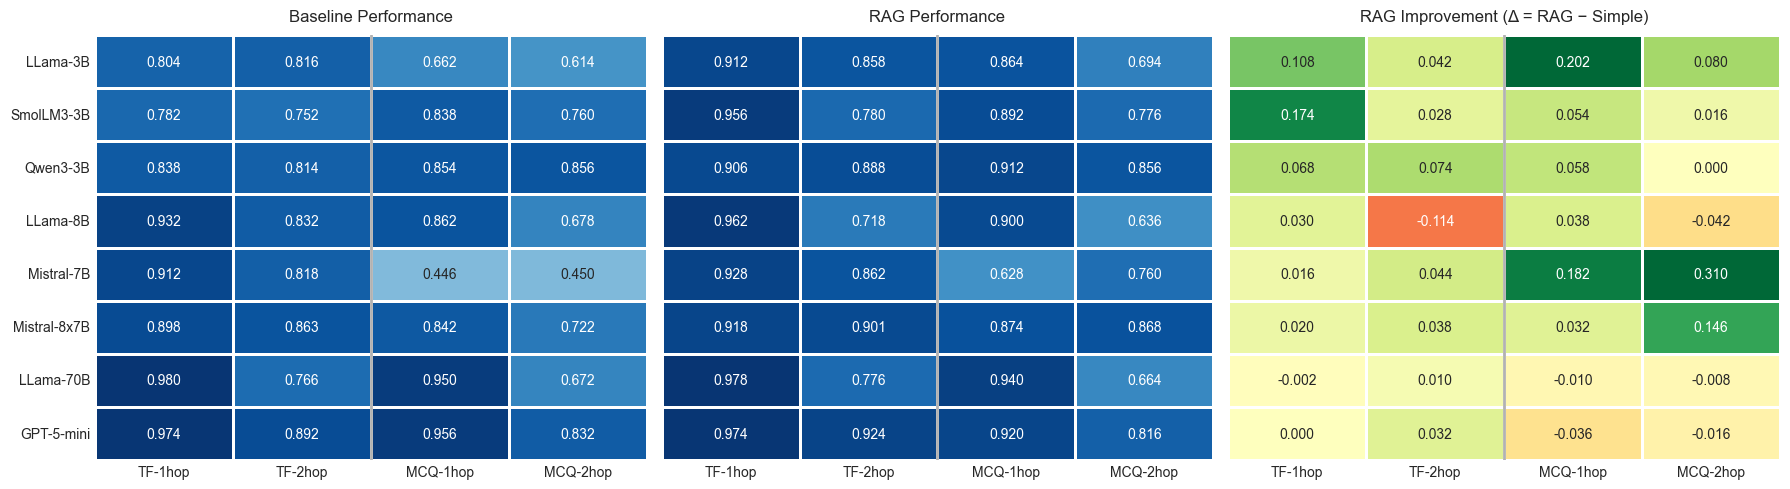

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'results_df' in globals(), "results_df is missing. Run your metrics aggregation first."

# --- Ensure models and configurations exist (avoid NameError) ---
if 'models' not in globals() or models is None:
    if 'csv_paths' in globals():
        models = [m for m in csv_paths.keys() if m in results_df['model'].unique()]
        extras = [m for m in results_df['model'].unique() if m not in models]
        models += sorted(extras)
    else:
        models = sorted(results_df['model'].unique().tolist())

# Preferred column order; keep only those present
desired_order = [('TF','1hop'), ('TF','2hop'), ('MCQ','1hop'), ('MCQ','2hop')]
present_pairs = set(zip(results_df['qtype'], results_df['hop']))
ordered_pairs = [p for p in desired_order if p in present_pairs]
configurations = [f"{qt}-{hp}" for (qt, hp) in ordered_pairs]

# Build matrices (NaN for missing cells so heatmap can display them cleanly)
rag_matrix = np.full((len(models), len(configurations)), np.nan)
baseline_matrix = np.full((len(models), len(configurations)), np.nan)

for i, model in enumerate(models):
    for j, cfg in enumerate(configurations):
        qtype, hop = cfg.split('-')
        row = results_df[
            (results_df['model'] == model) &
            (results_df['qtype'] == qtype) &
            (results_df['hop'] == hop)
        ]
        if not row.empty:
            baseline_matrix[i, j] = row['Simple'].values[0]
            rag_matrix[i, j]      = row['RAG'].values[0]

# Delta matrix (percentage points)
delta_matrix = (rag_matrix - baseline_matrix)

# =============================
# Plot: Panel 1 = Simple, Panel 2 = RAG, Panel 3 = Δ
# =============================
print("\nGenerating Side-by-side Heatmaps: Simple (left), RAG (middle), Δ (right)...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Panel 1: Baseline (Simple) ---
sns.heatmap(
    baseline_matrix,
    annot=True, fmt='.3f',
    cmap='Blues', vmin=0, vmax=1,
    xticklabels=configurations, yticklabels=models,
    cbar=False, ax=axes[0],
    linewidths=1, linecolor='white',
    square=False, annot_kws={'fontsize': 10}
)
axes[0].set_title('Baseline Performance', fontsize=12, pad=10)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
# Vertical split between TF and MCQ after 2 columns (if you kept desired_order)
if len(configurations) >= 3:
    axes[0].axvline(x=2, color='black', linewidth=2, alpha=0.3)
axes[0].set_xticklabels(configurations, rotation=0, ha='center', fontsize=10)
axes[0].set_yticklabels(models, rotation=0, fontsize=10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# --- Panel 2: RAG ---
sns.heatmap(
    rag_matrix,
    annot=True, fmt='.3f',
    cmap='Blues', vmin=0, vmax=1,
    xticklabels=configurations, yticklabels=models,
    cbar=False, ax=axes[1],
    linewidths=1, linecolor='white',
    square=False, annot_kws={'fontsize': 10}
)
axes[1].set_title('RAG Performance', fontsize=12, pad=10)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])  # tidy
if len(configurations) >= 3:
    axes[1].axvline(x=2, color='black', linewidth=2, alpha=0.3)
axes[1].set_xticklabels(configurations, rotation=0, ha='center', fontsize=10)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# --- Panel 3: Δ (RAG − Simple), percentage points ---
sns.heatmap(
    delta_matrix,  # still in [0..1] scale; we'll show ±0.2 like your prior code
    annot=True, fmt='.3f',
    cmap='RdYlGn', center=0, vmin=-0.2, vmax=0.2,
    xticklabels=configurations, yticklabels=models,
    cbar=False, ax=axes[2],
    linewidths=1, linecolor='white',
    square=False, annot_kws={'fontsize': 10}
)
axes[2].set_title('RAG Improvement (Δ = RAG − Simple)', fontsize=12, pad=10)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_yticklabels([])  # tidy
if len(configurations) >= 3:
    axes[2].axvline(x=2, color='black', linewidth=2, alpha=0.3)
axes[2].set_xticklabels(configurations, rotation=0, ha='center', fontsize=10)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('accuracy_heatmaps_triptych.png', dpi=300, bbox_inches='tight')
plt.savefig('accuracy_heatmaps_triptych.pdf', dpi=300, bbox_inches='tight')
plt.show()


Generating Side-by-side Heatmaps: Simple (left) and RAG (right)...


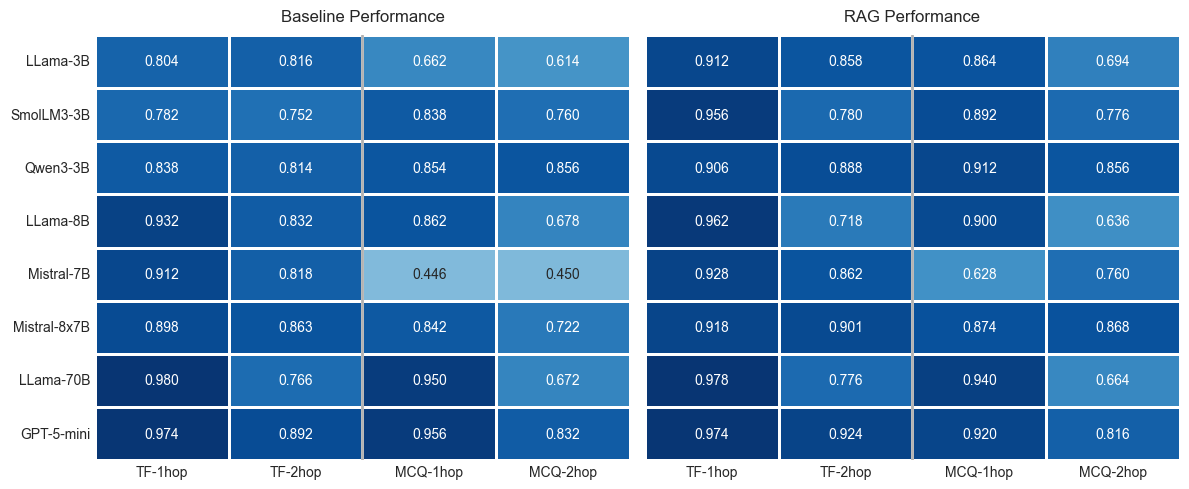

In [7]:
# =============================
# Side-by-side Heatmaps: Panel 1 = Simple, Panel 2 = RAG
# Uses the same colors: 'Blues' for accuracies
# Keeps the rest of your styling the same
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'results_df' in globals(), "results_df is missing. Run your metrics aggregation first."

# --- Ensure models and configurations exist (avoid NameError) ---
if 'models' not in globals() or models is None:
    if 'csv_paths' in globals():
        models = [m for m in csv_paths.keys() if m in results_df['model'].unique()]
        extras = [m for m in results_df['model'].unique() if m not in models]
        models += sorted(extras)
    else:
        models = sorted(results_df['model'].unique().tolist())

# Preferred column order; keep only those present
desired_order = [('TF','1hop'), ('TF','2hop'), ('MCQ','1hop'), ('MCQ','2hop')]
present_pairs = set(zip(results_df['qtype'], results_df['hop']))
ordered_pairs = [p for p in desired_order if p in present_pairs]
configurations = [f"{qt}-{hp}" for (qt, hp) in ordered_pairs]

# Build matrices (NaN for missing cells so heatmap can display them cleanly)
rag_matrix = np.full((len(models), len(configurations)), np.nan)
baseline_matrix = np.full((len(models), len(configurations)), np.nan)

for i, model in enumerate(models):
    for j, cfg in enumerate(configurations):
        qtype, hop = cfg.split('-')
        row = results_df[
            (results_df['model'] == model) &
            (results_df['qtype'] == qtype) &
            (results_df['hop'] == hop)
        ]
        if not row.empty:
            baseline_matrix[i, j] = row['Simple'].values[0]
            rag_matrix[i, j]      = row['RAG'].values[0]

# =============================
# Plot: Panel 1 = Simple, Panel 2 = RAG
# =============================
print("\nGenerating Side-by-side Heatmaps: Simple (left) and RAG (right)...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Panel 1: Baseline (Simple) ---
sns.heatmap(
    baseline_matrix,
    annot=True, fmt='.3f',
    cmap='Blues', vmin=0, vmax=1,
    xticklabels=configurations, yticklabels=models,
    cbar=False, ax=axes[0],
    linewidths=1, linecolor='white',
    square=False, annot_kws={'fontsize': 10}
)
axes[0].set_title('Baseline Performance', fontsize=12, pad=10)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
if len(configurations) >= 3:
    axes[0].axvline(x=2, linewidth=2, alpha=0.3, color='black')
axes[0].set_xticklabels(configurations, rotation=0, ha='center', fontsize=10)
axes[0].set_yticklabels(models, rotation=0, fontsize=10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# --- Panel 2: RAG ---
sns.heatmap(
    rag_matrix,
    annot=True, fmt='.3f',
    cmap='Blues', vmin=0, vmax=1,
    xticklabels=configurations, yticklabels=models,
    cbar=False, ax=axes[1],
    linewidths=1, linecolor='white',
    square=False, annot_kws={'fontsize': 10}
)
axes[1].set_title('RAG Performance', fontsize=12, pad=10)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])  # tidy
if len(configurations) >= 3:
    axes[1].axvline(x=2, linewidth=2, alpha=0.3, color='black')
axes[1].set_xticklabels(configurations, rotation=0, ha='center', fontsize=10)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('accuracy_heatmaps_side_by_side.png', dpi=300, bbox_inches='tight')
plt.savefig('accuracy_heatmaps_side_by_side.pdf', dpi=300, bbox_inches='tight')
plt.show()

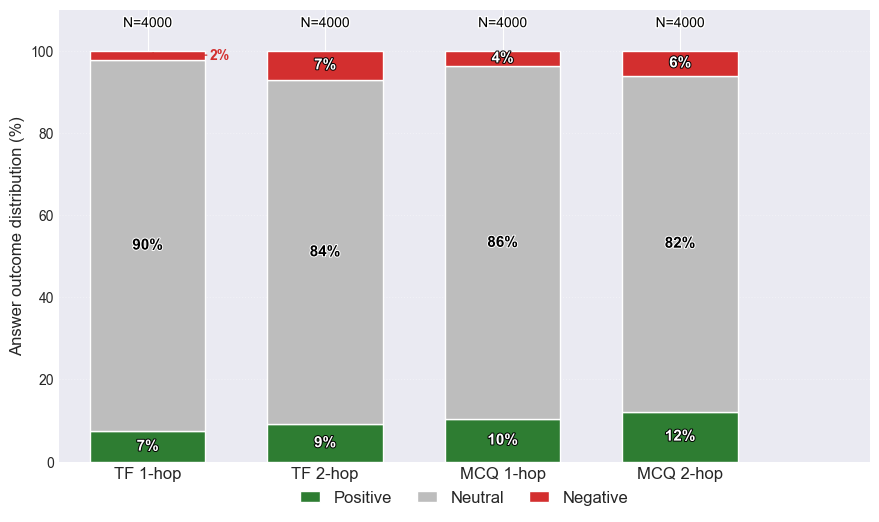

In [8]:
# =============================
# Figure 2: Context Impact (Help/Neutral/Hurt)
# =============================
import os
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# Datasets
datasets = [
    ("TF",  "1hop", "TF 1-hop"),
    ("TF",  "2hop", "TF 2-hop"),
    ("MCQ", "1hop", "MCQ 1-hop"),
    ("MCQ", "2hop", "MCQ 2-hop"),
]

# Colors
COL_HELP    = "#2E7D32"  # green
COL_NEUTRAL = "#BDBDBD"  # gray
COL_HURT    = "#D32F2F"  # red

def load_df(path):
    if not path or not os.path.exists(path):
        return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def per_question_impact(df, qtype):
    if df is None:
        return np.array([])
    
    if qtype == "TF":
        need = {'answer','with_context_parsed','without_context_parsed'}
        if not need.issubset(df.columns): return np.array([])
        y_true = df['answer'].astype(str).str.strip().str.lower()
        y_rag  = df['with_context_parsed'].astype(str).str.strip().str.lower()
        y_base = df['without_context_parsed'].astype(str).str.strip().str.lower()
    else:
        need = {'standardized_answer','with_context_parsed','without_context_parsed'}
        if not need.issubset(df.columns): return np.array([])
        y_true = df['standardized_answer'].astype(str).str.strip()
        y_rag  = df['with_context_parsed'].astype(str).str.strip()
        y_base = df['without_context_parsed'].astype(str).str.strip()

    mask = y_true.notna() & y_rag.notna() & y_base.notna()
    if mask.sum() == 0:
        return np.array([])

    y_true = y_true[mask].values
    y_rag  = y_rag[mask].values
    y_base = y_base[mask].values

    rag_correct  = (y_rag == y_true)
    base_correct = (y_base == y_true)

    impact = np.zeros_like(rag_correct, dtype=int)
    impact[(rag_correct) & (~base_correct)] = +1
    impact[(~rag_correct) & (base_correct)] = -1
    return impact

# Aggregate across models
records = []
all_models = list(csv_paths.keys())

for (qtype, hop, label) in datasets:
    helps = hurts = neutrals = total = 0
    for model in all_models:
        path = csv_paths.get(model, {}).get(qtype, {}).get(hop, None)
        imp = per_question_impact(load_df(path), qtype)
        if imp.size == 0:
            continue
        helps    += int((imp == +1).sum())
        hurts    += int((imp == -1).sum())
        neutrals += int((imp ==  0).sum())
        total    += int(imp.size)

    if total == 0:
        records.append({"dataset": label, "help": np.nan, "neutral": np.nan, "hurt": np.nan, "N": 0})
    else:
        records.append({
            "dataset": label,
            "help":   100.0 * helps    / total,
            "neutral":100.0 * neutrals / total,
            "hurt":   100.0 * hurts    / total,
            "N": total
        })

impact_df = pd.DataFrame(records)

# Plot
fig_w, fig_h = 8.9, 5.3
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

x = np.arange(len(impact_df))
help_vals    = impact_df['help'].values
neutral_vals = impact_df['neutral'].values
hurt_vals    = impact_df['hurt'].values

# Bars
b1 = ax.bar(x, help_vals,    color=COL_HELP,    edgecolor='white', width=0.65, label='Positive')
b2 = ax.bar(x, neutral_vals, bottom=help_vals,  color=COL_NEUTRAL, edgecolor='white', width=0.65, label='Neutral')
b3 = ax.bar(x, hurt_vals,    bottom=help_vals + neutral_vals, color=COL_HURT, edgecolor='white', width=0.65, label='Negative')

# Labels
LABEL_MIN_PCT = 3.0
OUT_X_OFFSET = 0.35

def internal_or_external_labels(vals, bottoms, xs, color_hex):
    rgb = np.array(mcolors.to_rgb(color_hex))
    luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    text_color = 'white' if luminance < 0.5 else 'black'
    outline = 'black' if text_color == 'white' else 'white'

    for v, btm, xx in zip(vals, bottoms, xs):
        if not np.isfinite(v) or v <= 0:
            continue
        y_mid = btm + v/2.0
        label = f"{v:.0f}%"

        if v >= LABEL_MIN_PCT:
            ax.text(xx, y_mid, label,
                    ha='center', va='center',
                    color=text_color, fontsize=11, fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=1.4, foreground=outline)])
        else:
            x_text = xx + OUT_X_OFFSET
            ax.annotate(label,
                        xy=(xx, y_mid), xycoords=('data','data'),
                        xytext=(x_text, y_mid), textcoords=('data','data'),
                        ha='left', va='center',
                        fontsize=10, fontweight='bold', color=color_hex,
                        arrowprops=dict(arrowstyle='-|>', lw=0.9, color=color_hex,
                                        shrinkA=0, shrinkB=0, mutation_scale=8))

internal_or_external_labels(help_vals,    np.zeros_like(help_vals), x, COL_HELP)
internal_or_external_labels(neutral_vals, help_vals,                x, COL_NEUTRAL)
internal_or_external_labels(hurt_vals,    help_vals + neutral_vals, x, COL_HURT)

# N labels above bars
for xx, N in zip(x, impact_df['N'].values):
    ax.text(xx, 105.0, f"N={int(N)}", ha='center', va='bottom',
            fontsize=10, color='black',
            path_effects=[pe.withStroke(linewidth=2.0, foreground='white')])

# Axes & cosmetics
ax.set_xticks(x)
ax.set_xticklabels(impact_df['dataset'].values, fontsize=12)
ax.set_ylim(0, 110)
ax.set_xlim(-0.5, len(x) - 0.5 + OUT_X_OFFSET + 0.22)
ax.set_ylabel('Answer outcome distribution (%)', fontsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.35)

# Legend
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03),
                ncol=3, frameon=False, fontsize=12, handlelength=1.2, columnspacing=1.5)

plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.savefig("context_impact_help_neutral_hurt.pdf", bbox_inches='tight')
plt.savefig("context_impact_help_neutral_hurt.png", dpi=400, bbox_inches='tight')
plt.show()

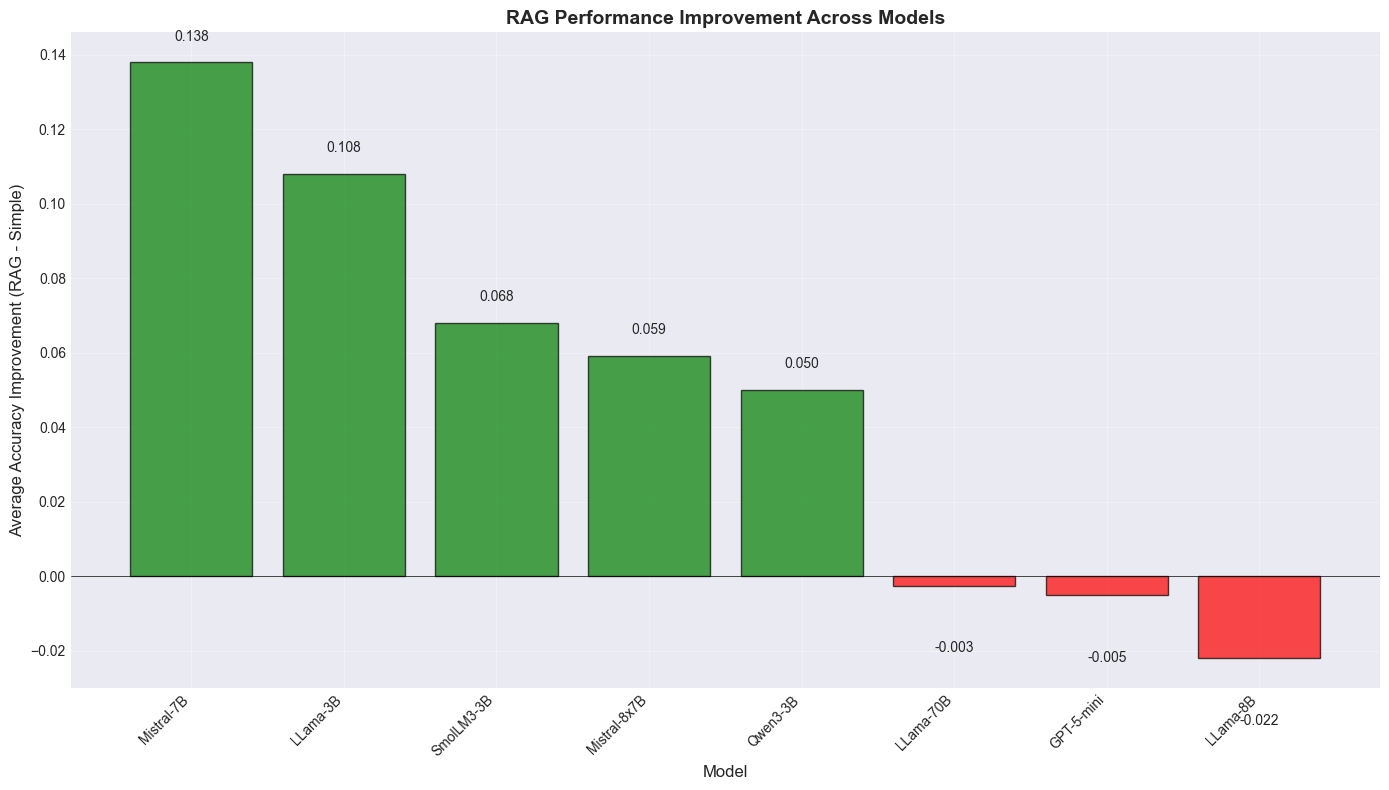

Models with positive RAG improvement: 5/8
Best performing model with RAG: Mistral-7B (+0.138)
Worst performing model with RAG: LLama-8B (-0.022)


In [9]:
# =============================
# Figure 3: Model Improvement Ranking
# =============================
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate mean improvement per model
improvement_by_model = results_df.groupby('model')['Improvement'].mean().sort_values(ascending=False)

# Create color map based on improvement values
colors = ['green' if x > 0 else 'red' for x in improvement_by_model.values]

bars = ax.bar(range(len(improvement_by_model)), improvement_by_model.values, 
              color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, improvement_by_model.values)):
    ax.text(bar.get_x() + bar.get_width()/2, val + (0.005 if val > 0 else -0.015),
            f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Average Accuracy Improvement (RAG - Simple)', fontsize=12)
ax.set_title('RAG Performance Improvement Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(improvement_by_model)))
ax.set_xticklabels(improvement_by_model.index, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_improvement_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Models with positive RAG improvement: {sum([1 for x in improvement_by_model.values if x > 0])}/{len(improvement_by_model)}")
print(f"Best performing model with RAG: {improvement_by_model.index[0]} (+{improvement_by_model.values[0]:.3f})")
print(f"Worst performing model with RAG: {improvement_by_model.index[-1]} ({improvement_by_model.values[-1]:.3f})")

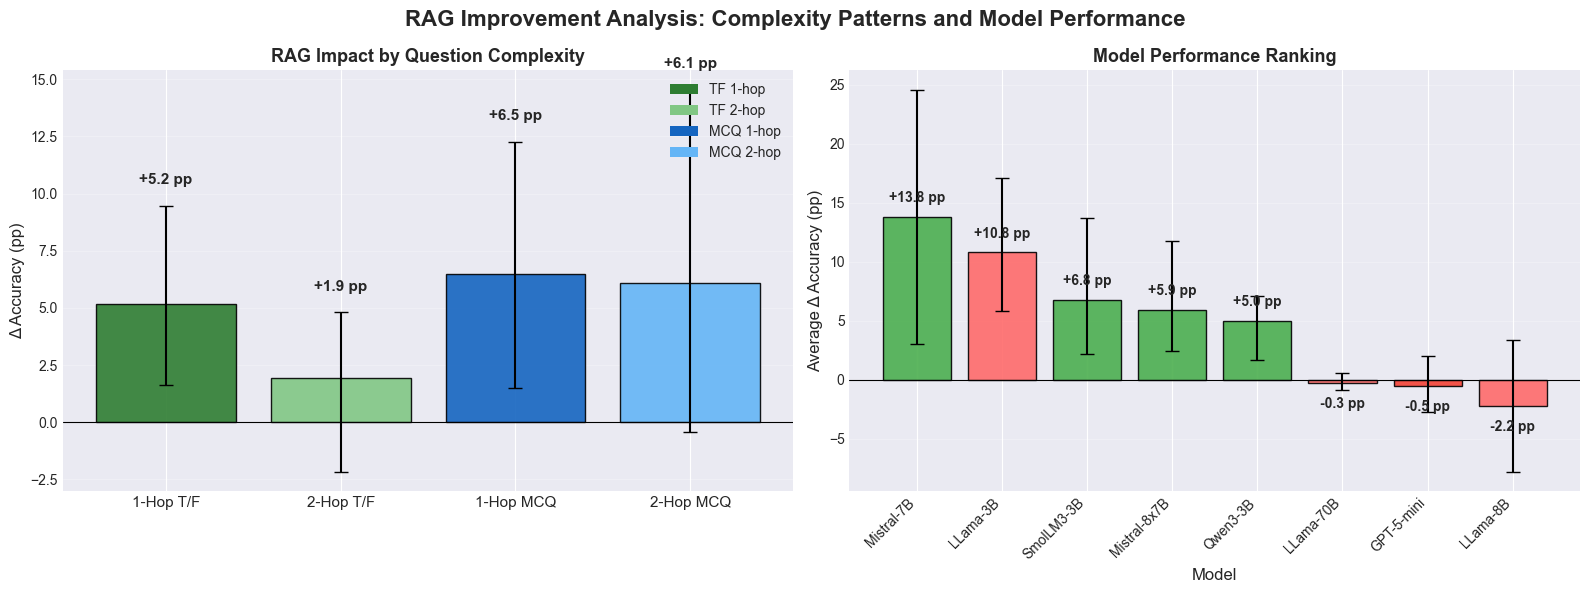

In [10]:
# =============================
# Figure 4: Complexity Analysis with Bootstrap CI
# =============================
from matplotlib.patches import Patch

# Question type mapping
question_type_map = {
    '1hop_tf':  '1-Hop T/F',
    '2hop_tf':  '2-Hop T/F',
    '1hop_mcq': '1-Hop MCQ',
    '2hop_mcq': '2-Hop MCQ'
}
complexity_order = ['1hop_tf', '2hop_tf', '1hop_mcq', '2hop_mcq']

# Colors
colors_qtype = {
    '1hop_tf':  '#2E7D32',  # dark green
    '2hop_tf':  '#81C784',  # light green
    '1hop_mcq': '#1565C0',  # dark blue
    '2hop_mcq': '#64B5F6',  # light blue
}

def bootstrap_mean_ci(x, n_boot=5000, alpha=0.05, seed=42):
    x = pd.Series(x).dropna().values
    if x.size == 0:
        return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    m = x.mean() * 100.0
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return m, lo*100.0, hi*100.0

# Create question type column
df = results_df.copy()
df['question_type'] = df['hop'].astype(str) + '_' + df['qtype'].str.lower().astype(str)

# Keep only types that exist
types_present = [qt for qt in complexity_order if qt in df['question_type'].unique()]

# Compute bootstrap means & CIs per type
agg_rows = []
for qt in types_present:
    m, lo, hi = bootstrap_mean_ci(df.loc[df['question_type'] == qt, 'Improvement'])
    agg_rows.append({'question_type': qt, 'mean_pp': m, 'lo_pp': lo, 'hi_pp': hi})
agg_type = pd.DataFrame(agg_rows)

# Compute for models
model_rows = []
for mname, g in df.groupby('model'):
    m, lo, hi = bootstrap_mean_ci(g['Improvement'])
    model_rows.append({'model': mname, 'mean_pp': m, 'lo_pp': lo, 'hi_pp': hi})
rank_df = pd.DataFrame(model_rows)
rank_df = rank_df.sort_values('mean_pp', ascending=False).reset_index(drop=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('RAG Improvement Analysis: Complexity Patterns and Model Performance',
             fontsize=16, fontweight='bold')

# Subplot 1: By Complexity
ax1 = axes[0]
x = np.arange(len(agg_type))
means = agg_type['mean_pp'].values
los   = agg_type['lo_pp'].values
his   = agg_type['hi_pp'].values
err   = np.vstack([means - los, his - means])

bar_colors = [colors_qtype[qt] for qt in agg_type['question_type']]
bars = ax1.bar(x, means, yerr=err, capsize=5,
               color=bar_colors, alpha=0.9, edgecolor='black', linewidth=1.0)

# Labels
for i, (bar, m, lo, hi) in enumerate(zip(bars, means, los, his)):
    y = hi + 0.8 if m >= 0 else lo - 0.8
    va = 'bottom' if m >= 0 else 'top'
    ax1.text(bar.get_x() + bar.get_width()/2, y,
             f"{m:+.1f} pp", ha='center', va=va, fontweight='bold', fontsize=11)

ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_ylabel('Δ Accuracy (pp)', fontsize=12)
ax1.set_title('RAG Impact by Question Complexity', fontsize=13, fontweight='bold', pad=6)
ax1.set_xticks(x)
ax1.set_xticklabels([question_type_map.get(qt, qt) for qt in agg_type['question_type']], fontsize=11)
ax1.grid(axis='y', alpha=0.25)

# Legend
legend_elements = [
    Patch(facecolor=colors_qtype.get('1hop_tf', '#2E7D32'),  label='TF 1-hop'),
    Patch(facecolor=colors_qtype.get('2hop_tf', '#81C784'),  label='TF 2-hop'),
    Patch(facecolor=colors_qtype.get('1hop_mcq', '#1565C0'), label='MCQ 1-hop'),
    Patch(facecolor=colors_qtype.get('2hop_mcq', '#64B5F6'), label='MCQ 2-hop'),
]
ax1.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=10)

# Subplot 2: By Model
ax2 = axes[1]
x2 = np.arange(len(rank_df))
means2 = rank_df['mean_pp'].values
los2   = rank_df['lo_pp'].values
his2   = rank_df['hi_pp'].values
err2   = np.vstack([means2 - los2, his2 - means2])

def color_for_model(name, mean_pp):
    if 'llama' in name.lower():
        return '#FF6B6B'
    return '#4CAF50' if mean_pp > 0 else '#F44336'

bar_colors2 = [color_for_model(m, v) for m, v in zip(rank_df['model'], means2)]
bars2 = ax2.bar(x2, means2, yerr=err2, capsize=5,
                color=bar_colors2, alpha=0.9, edgecolor='black', linewidth=1.0)

# Labels
for bar, m in zip(bars2, means2):
    y = m + (1.0 if m >= 0 else -1.2)
    va = 'bottom' if m >= 0 else 'top'
    ax2.text(bar.get_x() + bar.get_width()/2, y,
             f"{m:+.1f} pp", ha='center', va=va, fontweight='bold', fontsize=10)

ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Average Δ Accuracy (pp)', fontsize=12)
ax2.set_title('Model Performance Ranking', fontsize=13, fontweight='bold', pad=6)
ax2.set_xticks(x2)
ax2.set_xticklabels(rank_df['model'], rotation=45, ha='right', fontsize=10)
ax2.grid(axis='y', alpha=0.25)

plt.tight_layout()
plt.savefig('rag_improvement_complexity_model.pdf', bbox_inches='tight')
plt.savefig('rag_improvement_complexity_model.png', dpi=400, bbox_inches='tight')
plt.show()

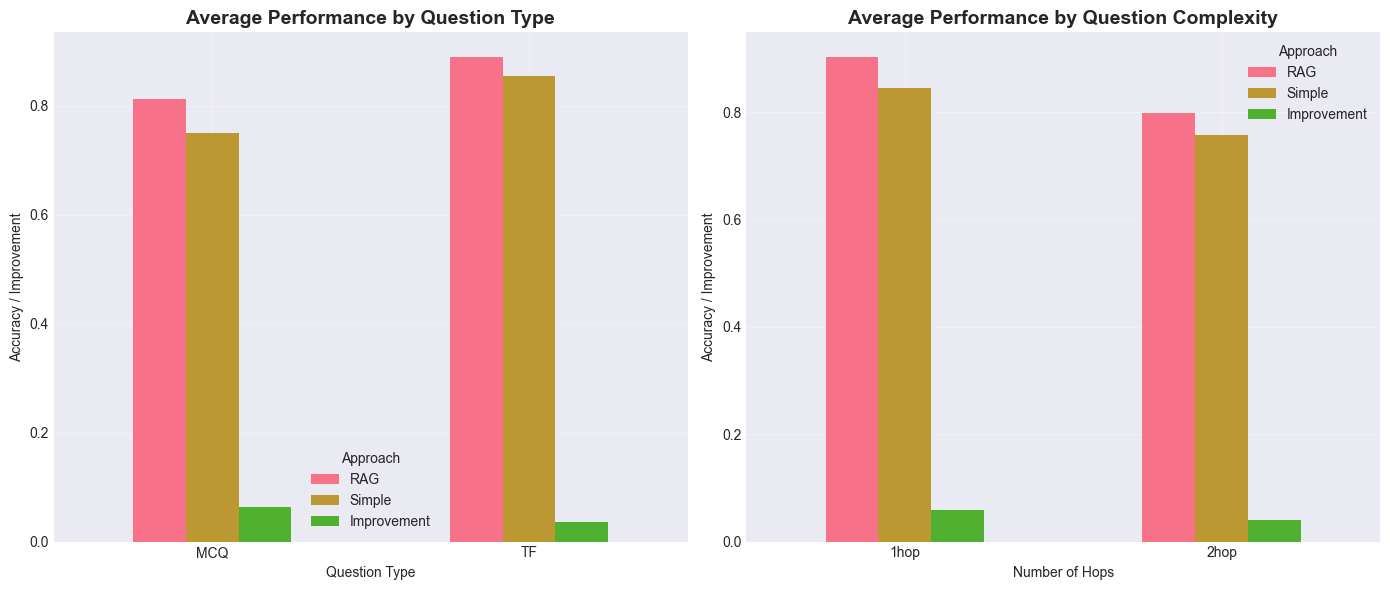


Question Type Statistics:
         RAG  Simple  Improvement
qtype                            
MCQ    0.812   0.750        0.063
TF     0.890   0.855        0.036

Complexity Statistics:
        RAG  Simple  Improvement
hop                             
1hop  0.904   0.846        0.058
2hop  0.799   0.759        0.040


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Average performance by question type
qtype_comparison = results_df.groupby('qtype')[['RAG', 'Simple', 'Improvement']].mean()
qtype_comparison.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Average Performance by Question Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Question Type')
axes[0].set_ylabel('Accuracy / Improvement')
axes[0].legend(title='Approach')
axes[0].grid(True, alpha=0.3)

# Average performance by complexity (hops)
hop_comparison = results_df.groupby('hop')[['RAG', 'Simple', 'Improvement']].mean()
hop_comparison.plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Average Performance by Question Complexity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Hops')
axes[1].set_ylabel('Accuracy / Improvement')
axes[1].legend(title='Approach')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nQuestion Type Statistics:")
print(qtype_comparison.round(3))
print("\nComplexity Statistics:")
print(hop_comparison.round(3))

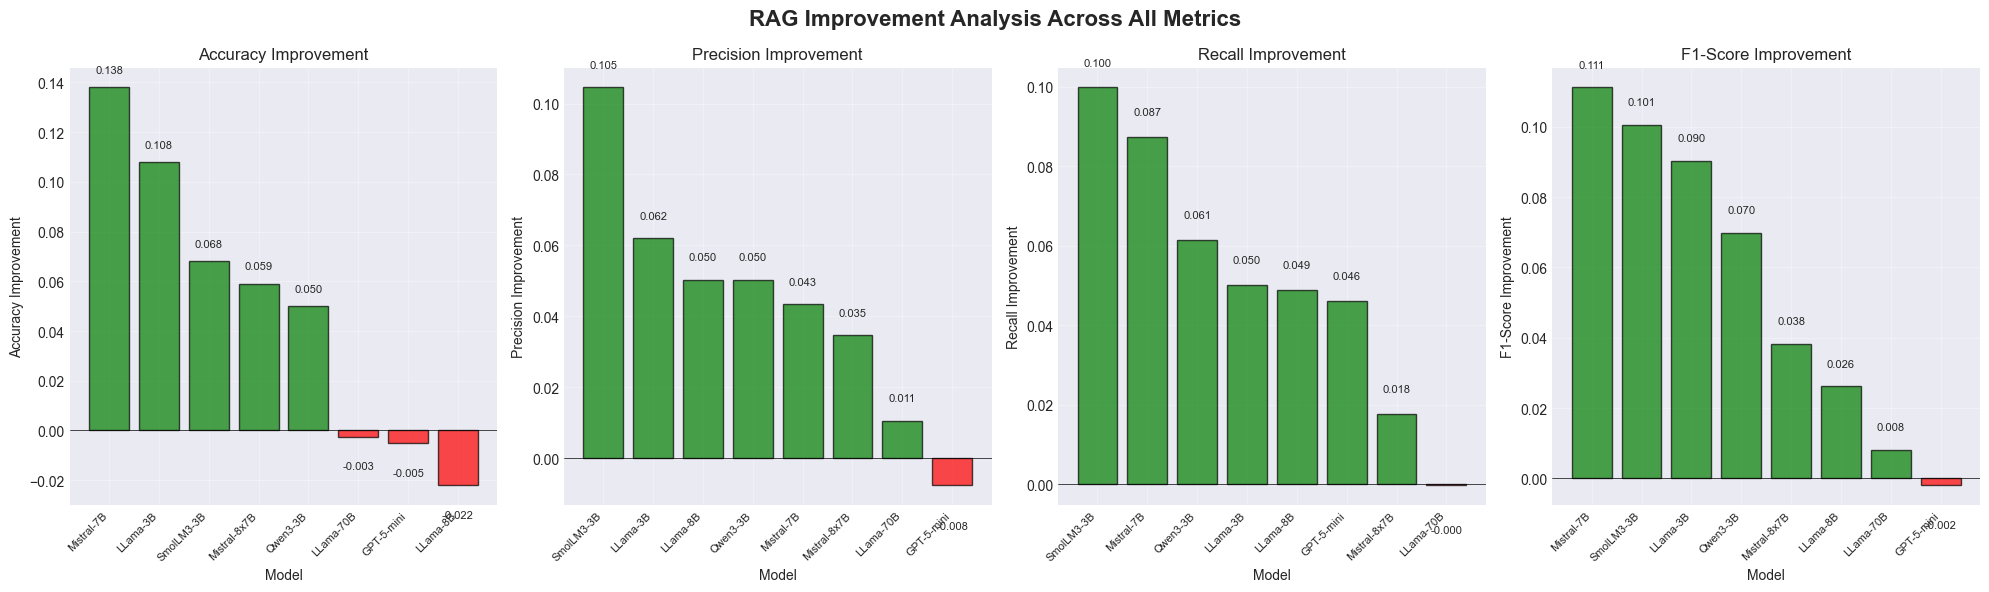


SUMMARY: Models with Positive RAG Improvement
Accuracy  : 5/8 models show improvement
Precision : 7/8 models show improvement
Recall    : 7/8 models show improvement
F1        : 7/8 models show improvement


In [12]:
# Analyze improvement across all metrics
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('RAG Improvement Analysis Across All Metrics', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    
    improvement_col = f'Improvement_{metric}'
    improvement_by_model = results_df.groupby('model')[improvement_col].mean().sort_values(ascending=False)
    
    colors = ['green' if x > 0 else 'red' for x in improvement_by_model.values]
    
    bars = ax.bar(range(len(improvement_by_model)), improvement_by_model.values, 
                  color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for j, (bar, val) in enumerate(zip(bars, improvement_by_model.values)):
        ax.text(bar.get_x() + bar.get_width()/2, 
                val + (0.005 if val > 0 else -0.01),
                f'{val:.3f}', ha='center', 
                va='bottom' if val > 0 else 'top', fontsize=8)
    
    ax.set_xlabel('Model', fontsize=10)
    ax.set_ylabel(f'{metric_name} Improvement', fontsize=10)
    ax.set_title(f'{metric_name} Improvement')
    ax.set_xticks(range(len(improvement_by_model)))
    ax.set_xticklabels(improvement_by_model.index, rotation=45, ha='right', fontsize=8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary of improvements
print("\nSUMMARY: Models with Positive RAG Improvement")
print("=" * 60)
for metric in metrics:
    improvement_col = f'Improvement_{metric}'
    positive_count = (results_df.groupby('model')[improvement_col].mean() > 0).sum()
    total_count = results_df['model'].nunique()
    print(f"{metric.capitalize():10s}: {positive_count}/{total_count} models show improvement")

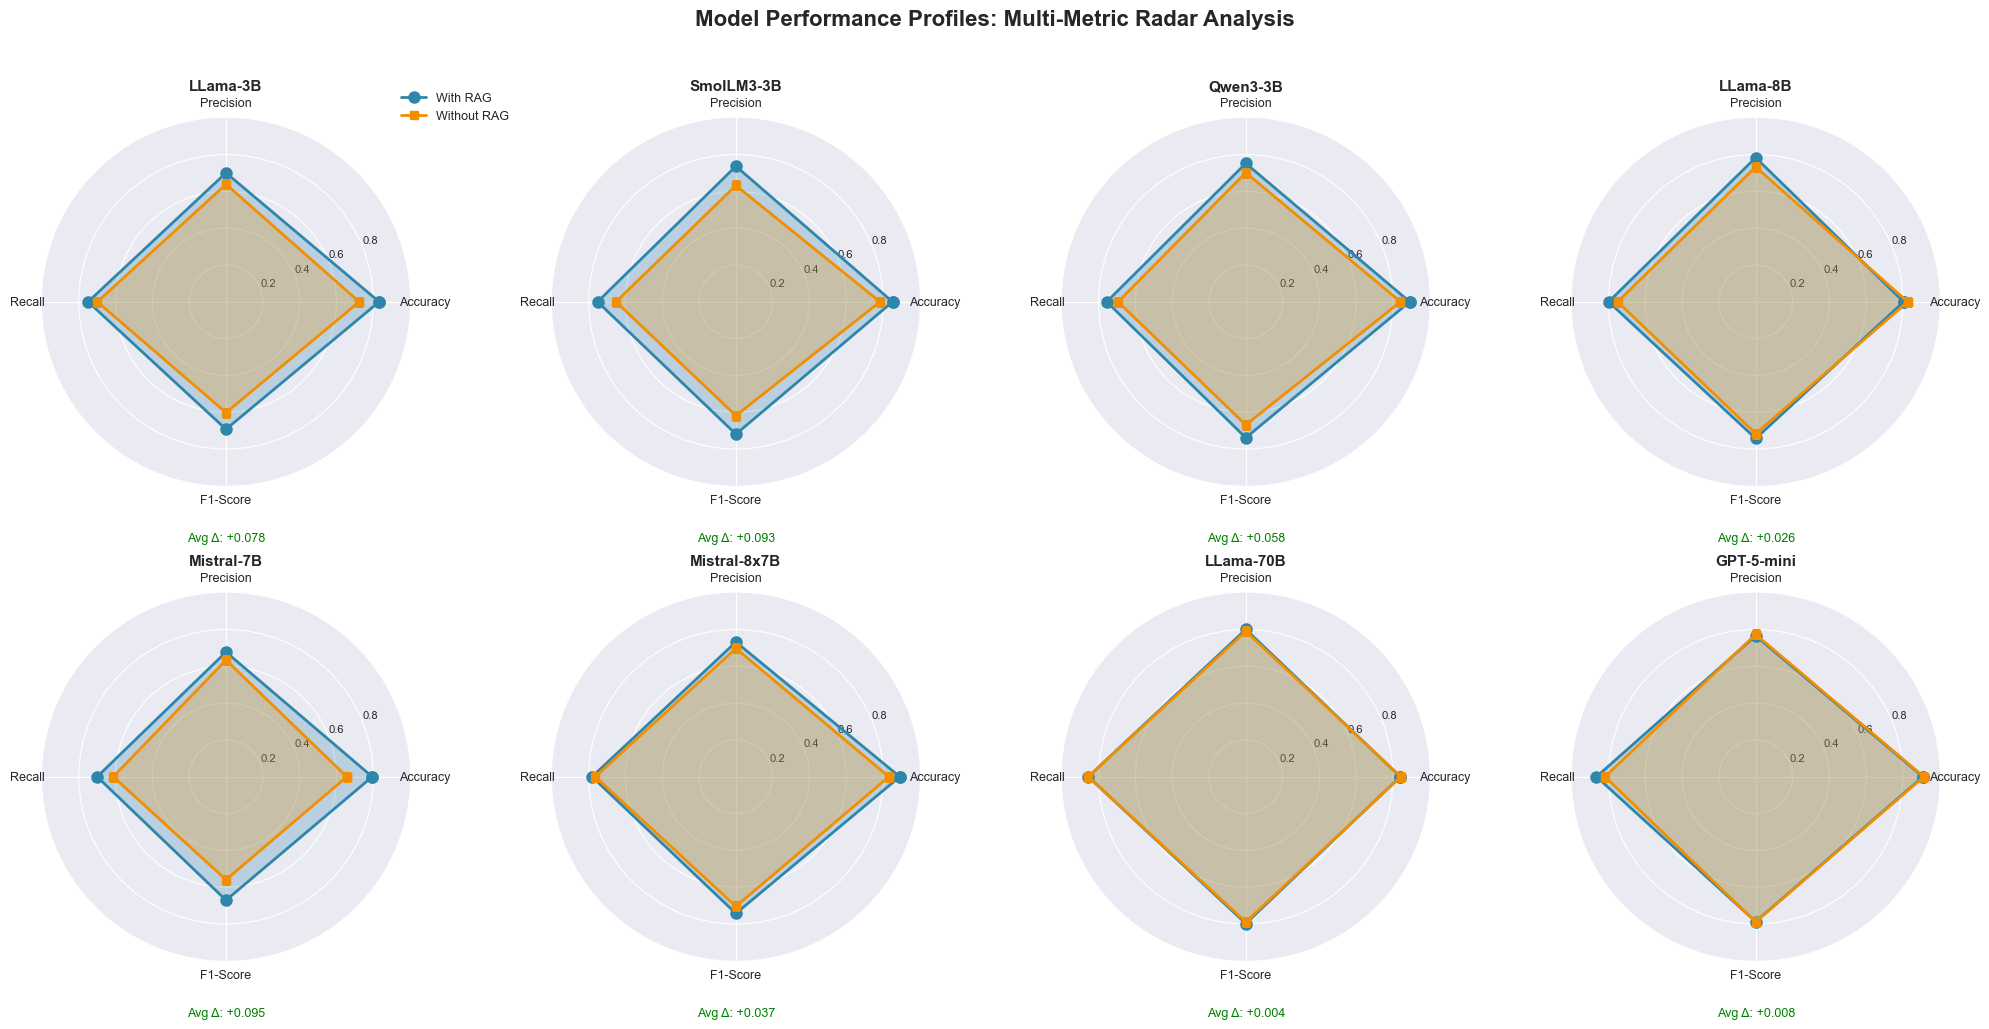

In [13]:
# Radar/Spider Chart per Model - Performance Profile
from math import pi

fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Model Performance Profiles: Multi-Metric Radar Analysis', fontsize=16, fontweight='bold', y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Define metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Get unique models
models = results_df['model'].unique()[:8]  # Take first 8 models

# Create radar chart for each model
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get model data (average across all question types)
    model_data = results_df[results_df['model'] == model]
    
    # Calculate average scores for each metric
    rag_scores = []
    simple_scores = []
    
    for metric in metrics:
        rag_avg = model_data[f'RAG_{metric}'].mean()
        simple_avg = model_data[f'Simple_{metric}'].mean()
        rag_scores.append(rag_avg)
        simple_scores.append(simple_avg)
    
    # Number of variables
    num_vars = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Complete the loop for scores
    rag_scores += rag_scores[:1]
    simple_scores += simple_scores[:1]
    
    # Plot RAG performance
    ax.plot(angles, rag_scores, 'o-', linewidth=2, label='With RAG', color='#2E86AB', markersize=8)
    ax.fill(angles, rag_scores, alpha=0.25, color='#2E86AB')
    
    # Plot Simple performance
    ax.plot(angles, simple_scores, 's-', linewidth=2, label='Without RAG', color='#F18F01', markersize=6)
    ax.fill(angles, simple_scores, alpha=0.25, color='#F18F01')
    
    # Fix axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, size=9)
    
    # Set y-axis limits and grid
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], size=8)
    ax.grid(True)
    
    # Add model name as title
    ax.set_title(model, size=11, fontweight='bold', pad=20)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    
    # Add performance improvement annotation
    avg_improvement = np.mean([rag_scores[i] - simple_scores[i] for i in range(len(metrics))])
    ax.text(0.5, -0.15, f'Avg Δ: {avg_improvement:+.3f}', 
            transform=ax.transAxes, ha='center', fontsize=9,
            color='green' if avg_improvement > 0 else 'red')

# Hide any unused subplots
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

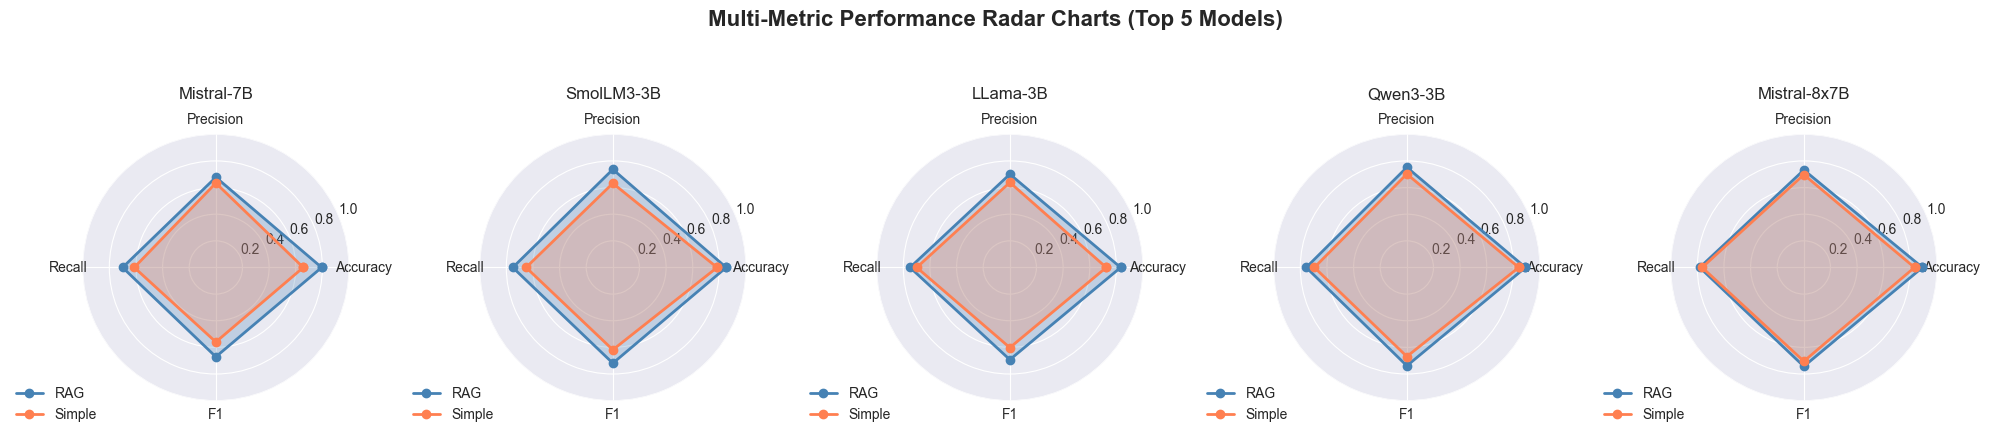

In [14]:
# Create radar charts for top models
from math import pi

# Select top 5 models based on average F1 improvement
top_models = results_df.groupby('model')['Improvement_f1'].mean().nlargest(5).index

fig, axes = plt.subplots(1, len(top_models), figsize=(20, 5), subplot_kw=dict(projection='polar'))
fig.suptitle('Multi-Metric Performance Radar Charts (Top 5 Models)', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, model in enumerate(top_models):
    ax = axes[idx] if len(top_models) > 1 else axes
    
    model_data = results_df[results_df['model'] == model]
    
    # Calculate average scores for each metric
    rag_scores = [model_data[f'RAG_{m}'].mean() for m in metrics]
    simple_scores = [model_data[f'Simple_{m}'].mean() for m in metrics]
    
    # Number of variables
    num_vars = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Complete the loop
    rag_scores += rag_scores[:1]
    simple_scores += simple_scores[:1]
    
    # Plot
    ax.plot(angles, rag_scores, 'o-', linewidth=2, label='RAG', color='steelblue')
    ax.fill(angles, rag_scores, alpha=0.25, color='steelblue')
    ax.plot(angles, simple_scores, 'o-', linewidth=2, label='Simple', color='coral')
    ax.fill(angles, simple_scores, alpha=0.25, color='coral')
    
    # Fix axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title(model, size=12, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)

plt.tight_layout()
plt.show()

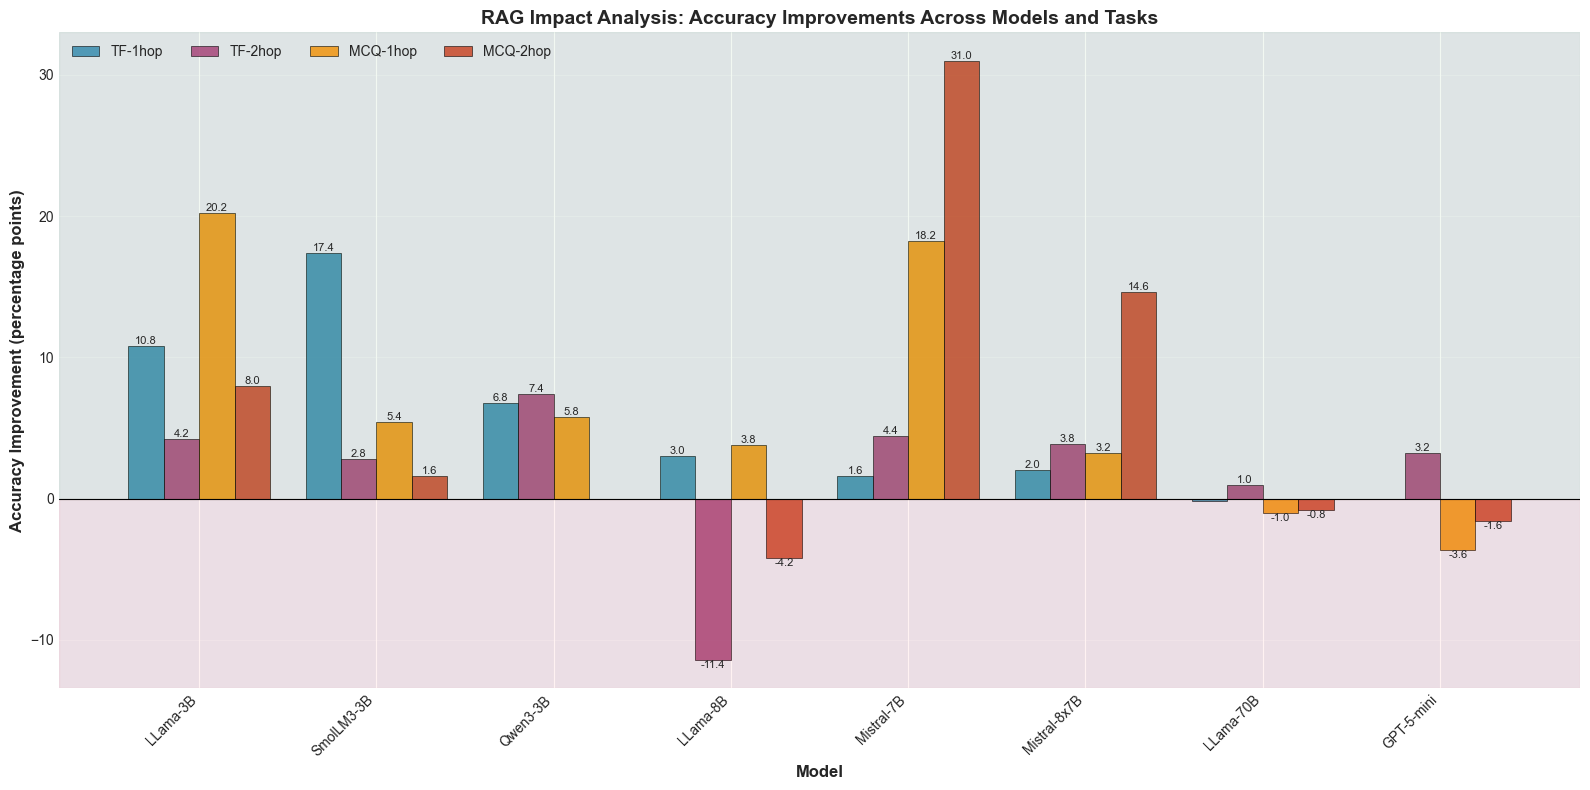


RAG Impact Summary:
--------------------------------------------------
TF-1hop   : Avg = +5.2%, Positive impact on 6/8 models
TF-2hop   : Avg = +1.9%, Positive impact on 7/8 models
MCQ-1hop  : Avg = +6.5%, Positive impact on 6/8 models
MCQ-2hop  : Avg = +6.1%, Positive impact on 4/8 models

Overall: Avg = +4.9%, Range = [-11.4%, 31.0%]
Models with positive impact: 23/32 cases


In [15]:
# RAG Impact Analysis - Grouped Bar Chart
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data for grouped bar chart
models = results_df['model'].unique()
conditions = [('TF', '1hop'), ('TF', '2hop'), ('MCQ', '1hop'), ('MCQ', '2hop')]
condition_labels = ['TF-1hop', 'TF-2hop', 'MCQ-1hop', 'MCQ-2hop']

# Calculate improvements for each model and condition
improvements = {condition: [] for condition in condition_labels}

for model in models:
    for (qtype, hop), label in zip(conditions, condition_labels):
        data = results_df[(results_df['model'] == model) & 
                         (results_df['qtype'] == qtype) & 
                         (results_df['hop'] == hop)]
        if len(data) > 0:
            improvement = data['Improvement_accuracy'].values[0] * 100  # Convert to percentage
        else:
            improvement = 0
        improvements[label].append(improvement)

# Set up bar positions
x = np.arange(len(models))
width = 0.2  # Width of each bar
multiplier = 0

# Define colors for each condition
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Create grouped bars
for (attribute, values), color in zip(improvements.items(), colors):
    offset = width * multiplier
    bars = ax.bar(x + offset, values, width, label=attribute, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.5:  # Only show label if improvement is significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom' if height > 0 else 'top',
                   fontsize=8)
    
    multiplier += 1

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Customize the plot
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Improvement (percentage points)', fontsize=12, fontweight='bold')
ax.set_title('RAG Impact Analysis: Accuracy Improvements Across Models and Tasks', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left', ncol=4, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

# Set y-axis limits for better visibility
y_min = min([min(vals) for vals in improvements.values()]) - 2
y_max = max([max(vals) for vals in improvements.values()]) + 2
ax.set_ylim([y_min, y_max])

# Add background shading for positive/negative regions
ax.axhspan(0, y_max, alpha=0.05, color='green')
ax.axhspan(y_min, 0, alpha=0.05, color='red')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRAG Impact Summary:")
print("-" * 50)
for condition in condition_labels:
    values = improvements[condition]
    positive_count = sum(1 for v in values if v > 0)
    avg_improvement = np.mean(values)
    print(f"{condition:10s}: Avg = {avg_improvement:+.1f}%, Positive impact on {positive_count}/{len(values)} models")

# Overall statistics
all_improvements = [v for vals in improvements.values() for v in vals]
print(f"\nOverall: Avg = {np.mean(all_improvements):+.1f}%, "
      f"Range = [{min(all_improvements):.1f}%, {max(all_improvements):.1f}%]")
print(f"Models with positive impact: {sum(1 for v in all_improvements if v > 0)}/{len(all_improvements)} cases")

## Statistical Summaries

In [16]:
# =============================
# Comprehensive Statistical Summary
# =============================

# Overall statistics
print("=" * 80)
print("OVERALL PERFORMANCE METRICS")
print("=" * 80)
print(f"Average RAG Accuracy: {results_df['RAG'].mean():.3f} ± {results_df['RAG'].std():.3f}")
print(f"Average Simple Accuracy: {results_df['Simple'].mean():.3f} ± {results_df['Simple'].std():.3f}")
print(f"Average Improvement: {results_df['Improvement'].mean():.3f} ± {results_df['Improvement'].std():.3f}")
print(f"Maximum Improvement: {results_df['Improvement'].max():.3f} ({results_df.loc[results_df['Improvement'].idxmax(), 'model']})")
print(f"Minimum Improvement: {results_df['Improvement'].min():.3f} ({results_df.loc[results_df['Improvement'].idxmin(), 'model']})")

# Percentage of models that benefit from RAG
positive_improvement = (results_df['Improvement'] > 0).sum() / len(results_df) * 100
print(f"\nPercentage of experiments with positive RAG improvement: {positive_improvement:.1f}%")

# By question type and complexity
print("\n" + "=" * 80)
print("PERFORMANCE BY QUESTION TYPE AND COMPLEXITY")
print("=" * 80)

summary_stats = results_df.groupby(['qtype', 'hop']).agg({
    'RAG': ['mean', 'std'],
    'Simple': ['mean', 'std'],
    'Improvement': ['mean', 'std']
}).round(3)

print(summary_stats)

# Model-wise summary
print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

model_summary = results_df.groupby('model')[['RAG', 'Simple', 'Improvement']].mean().round(3)
model_summary = model_summary.sort_values('Improvement', ascending=False)
print(model_summary)

OVERALL PERFORMANCE METRICS
Average RAG Accuracy: 0.851 ± 0.099
Average Simple Accuracy: 0.802 ± 0.130
Average Improvement: 0.049 ± 0.082
Maximum Improvement: 0.310 (Mistral-7B)
Minimum Improvement: -0.114 (LLama-8B)

Percentage of experiments with positive RAG improvement: 71.9%

PERFORMANCE BY QUESTION TYPE AND COMPLEXITY
              RAG        Simple        Improvement       
             mean    std   mean    std        mean    std
qtype hop                                                
MCQ   1hop  0.866  0.099  0.801  0.170       0.065  0.085
      2hop  0.759  0.087  0.698  0.129       0.061  0.117
TF    1hop  0.942  0.029  0.890  0.075       0.052  0.062
      2hop  0.838  0.072  0.819  0.046       0.019  0.057

MODEL PERFORMANCE SUMMARY
                RAG  Simple  Improvement
model                                   
Mistral-7B    0.794   0.656        0.138
LLama-3B      0.832   0.724        0.108
SmolLM3-3B    0.851   0.783        0.068
Mistral-8x7B  0.890   0.831        0